In [18]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from collections import defaultdict

### Optimise the model for predicting whether an image has or hasn't a tumor on the mixed dataset

In [88]:
batch_size = 64
image_height = 128
image_width = 128

In [75]:
batch_size = 32
image_height = 128
image_width = 128

In [109]:
train = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='training',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)


Found 2265 files belonging to 2 classes.
Using 1586 files for training.


In [110]:
validate = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='validation',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 2265 files belonging to 2 classes.
Using 679 files for validation.


In [111]:
class_names = train.class_names
class_names

['no', 'yes']

In [112]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 128, 128, 3)
(64,)


In [113]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
validate = validate.cache().prefetch(buffer_size=AUTOTUNE)

In [114]:
normalization_layer = layers.Rescaling(1./255)
# 1. keeps it at same scale
# can make it grow or shrink by changing factor value
# eg 0.5 or 2.0

In [115]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.5230817


In [167]:
num_classes = len(class_names)


model = Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [168]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [169]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 64)      

In [170]:
%%time

epochs=12
history = model.fit(
  train,
  validation_data=validate,
  epochs=epochs
)

Epoch 1/12
25/25 [==============================] - 119s 5s/step - loss: 0.6215 - accuracy: 0.6393 - val_loss: 0.5477 - val_accuracy: 0.7378
Epoch 2/12
25/25 [==============================] - 117s 5s/step - loss: 0.4934 - accuracy: 0.7617 - val_loss: 0.5230 - val_accuracy: 0.7570
Epoch 3/12
25/25 [==============================] - 117s 5s/step - loss: 0.4431 - accuracy: 0.8102 - val_loss: 0.4045 - val_accuracy: 0.8277
Epoch 4/12
25/25 [==============================] - 141s 6s/step - loss: 0.3163 - accuracy: 0.8689 - val_loss: 0.3661 - val_accuracy: 0.8557
Epoch 5/12
25/25 [==============================] - 119s 5s/step - loss: 0.2077 - accuracy: 0.9212 - val_loss: 0.3004 - val_accuracy: 0.8954
Epoch 6/12
25/25 [==============================] - 117s 5s/step - loss: 0.1213 - accuracy: 0.9571 - val_loss: 0.2430 - val_accuracy: 0.9161
Epoch 7/12
25/25 [==============================] - 118s 5s/step - loss: 0.0862 - accuracy: 0.9760 - val_loss: 0.1993 - val_accuracy: 0.9455
Epoch 8/12
25

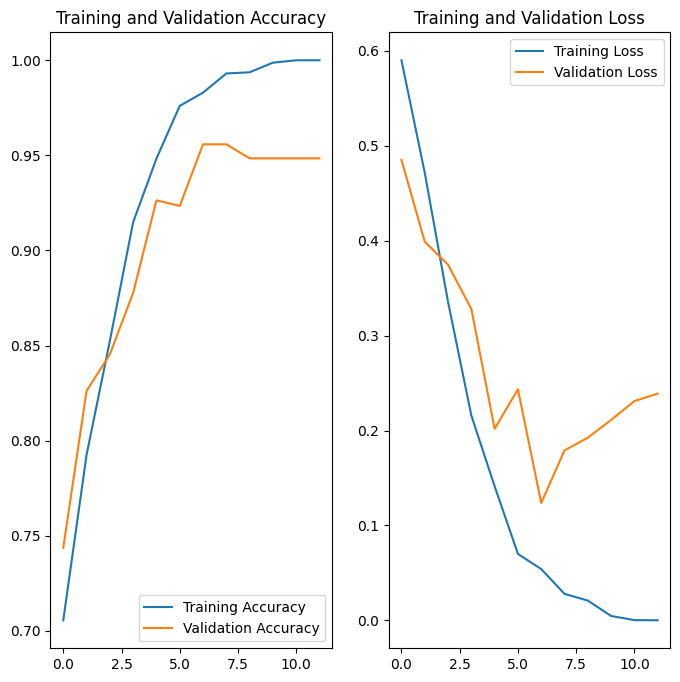

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- validation loss did not fall with training loss 
- forgot to add data augmentation and drop out

In [19]:
train2 = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='training',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)


Found 2265 files belonging to 2 classes.
Using 1586 files for training.


In [20]:
validate2 = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='validation',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 2265 files belonging to 2 classes.
Using 679 files for validation.


In [21]:
class_names = train2.class_names
class_names

['no', 'yes']

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train2 = train2.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
validate2 = validate2.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)


In [28]:
normalized_ds = train2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99891555


In [29]:
data_augmentation = tf.keras.Sequential([
    # flips it upside down
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    # moves randomly at angle of 0.2 radians
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    # random zoom kept small because dont want to exclude tumour
    # may remove later
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

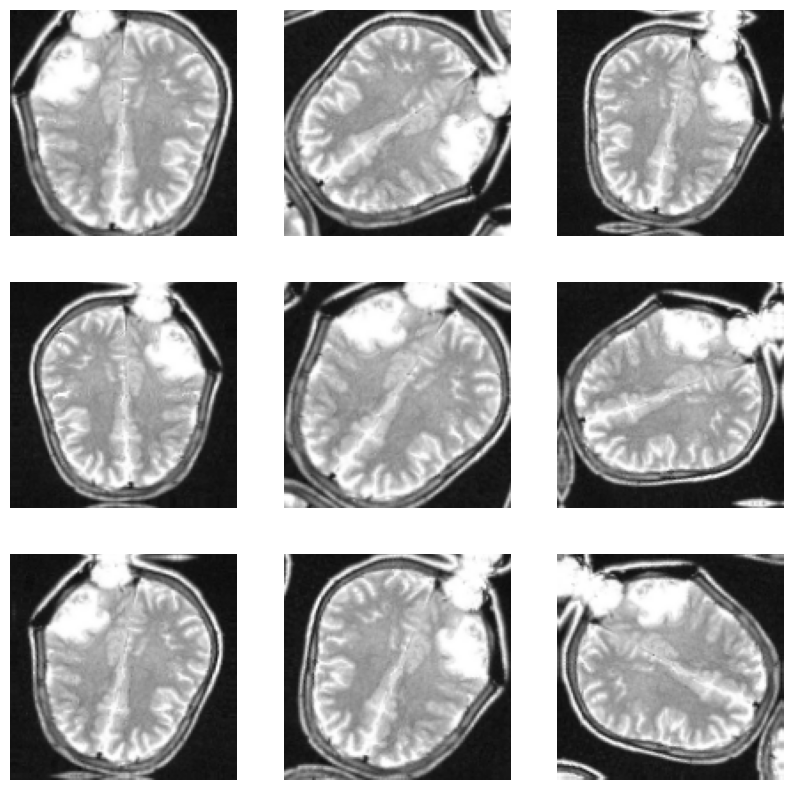

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train2.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [33]:
num_classes = len(class_names)


model2 = Sequential([
    data_augmentation, 
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Dropout(0.2), #dropout added
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [34]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
%%time

epochs=12
history = model2.fit(
  train2,
  validation_data=validate2,
  epochs=epochs
)

Epoch 1/12
50/50 [==============================] - 20s 226ms/step - loss: 0.6283 - accuracy: 0.6665 - val_loss: 0.5595 - val_accuracy: 0.7526
Epoch 2/12
50/50 [==============================] - 11s 214ms/step - loss: 0.5503 - accuracy: 0.7295 - val_loss: 0.5494 - val_accuracy: 0.7747
Epoch 3/12
50/50 [==============================] - 10s 210ms/step - loss: 0.5241 - accuracy: 0.7478 - val_loss: 0.4668 - val_accuracy: 0.7865
Epoch 4/12
50/50 [==============================] - 11s 225ms/step - loss: 0.5028 - accuracy: 0.7585 - val_loss: 0.4717 - val_accuracy: 0.7982
Epoch 5/12
50/50 [==============================] - 21s 421ms/step - loss: 0.4903 - accuracy: 0.7724 - val_loss: 0.4651 - val_accuracy: 0.7953
Epoch 6/12
50/50 [==============================] - 30s 582ms/step - loss: 0.4672 - accuracy: 0.7856 - val_loss: 0.5056 - val_accuracy: 0.7909
Epoch 7/12
50/50 [==============================] - 21s 405ms/step - loss: 0.4496 - accuracy: 0.7963 - val_loss: 0.5786 - val_accuracy: 0.7909

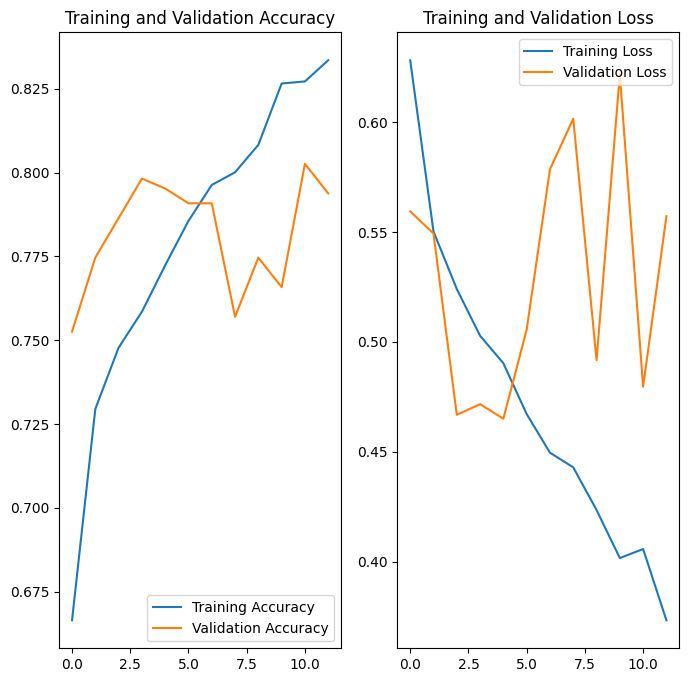

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- not super promising
- dropout may be too high 
- may be workable to include more epochs

In [40]:
num_classes = len(class_names)


model3 = Sequential([
    data_augmentation, 
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(320, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),
    layers.Dropout(0.13), #dropout added
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [41]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
%%time

epochs=25
history = model3.fit(
  train2,
  validation_data=validate2,
  epochs=epochs
)

Epoch 1/25
50/50 [==============================] - 20s 265ms/step - loss: 0.6068 - accuracy: 0.6526 - val_loss: 0.6930 - val_accuracy: 0.6804
Epoch 2/25
50/50 [==============================] - 12s 247ms/step - loss: 0.5299 - accuracy: 0.7434 - val_loss: 0.4924 - val_accuracy: 0.7791
Epoch 3/25
50/50 [==============================] - 13s 251ms/step - loss: 0.5122 - accuracy: 0.7705 - val_loss: 0.4926 - val_accuracy: 0.7541
Epoch 4/25
50/50 [==============================] - 12s 249ms/step - loss: 0.4852 - accuracy: 0.7724 - val_loss: 0.5492 - val_accuracy: 0.7408
Epoch 5/25
50/50 [==============================] - 33s 648ms/step - loss: 0.4581 - accuracy: 0.7932 - val_loss: 0.5497 - val_accuracy: 0.7496
Epoch 6/25
50/50 [==============================] - 25s 504ms/step - loss: 0.4669 - accuracy: 0.7724 - val_loss: 0.4517 - val_accuracy: 0.8041
Epoch 7/25
50/50 [==============================] - 34s 694ms/step - loss: 0.4191 - accuracy: 0.8071 - val_loss: 0.7338 - val_accuracy: 0.7261

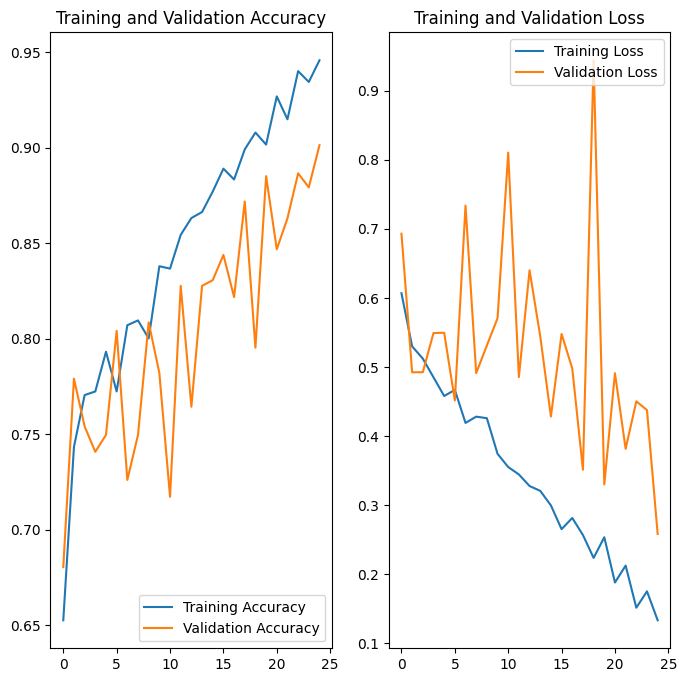

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- shows it improves with more epochs so may have been under training previously
- will compare these 3 models on training data to see if they were overfitted

In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 64)       

In [57]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

In [58]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

### Evlaution on test data

In [60]:
models = [model, model2, model3]
modelnames = ["model", "model2", "model3"]

In [65]:
from collections import defaultdict

In [66]:
%%time

for moo in range(len(models)):
    MODELX= models[moo]


    correct_yes_count = 0
    correct_no_count = 0
    count_yes = 0
    count_no = 0

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = MODELX.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Model Name: \t {modelnames[moo]}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}")
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))




Model Name: 	 model
Accuracy: 95.72%
no: 16 / 490
rate of failure: 	 3.2653061224489797
yes: 26 / 491
rate of failure: 	 5.295315682281059
Model Name: 	 model2
Accuracy: 76.15%
no: 211 / 490
rate of failure: 	 43.06122448979592
yes: 23 / 491
rate of failure: 	 4.684317718940937
Model Name: 	 model3
Accuracy: 88.28%
no: 85 / 490
rate of failure: 	 17.346938775510203
yes: 30 / 491
rate of failure: 	 6.109979633401222
CPU times: total: 1min 37s
Wall time: 3min 5s


- first model with least data variation has highest accuracy
- might improve with more epochs
- this dataset appears mcuh easier to work with than the other one
- want to test the models on the dataset with the different format to see how adaptable they are 
- suspect that the 3rd model actually identifies tumors better despite lower score

In [68]:
%%time

for moo in range(len(models)):
    MODELX= models[moo]


    correct_yes_count = 0
    correct_no_count = 0
    count_yes = 0
    count_no = 0

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./wdDataSet_ynFormat_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './wdDataSet_ynFormat_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = MODELX.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Model Name: \t {modelnames[moo]}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}")
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))




Model Name: 	 model
Accuracy: 62.78%
no: 34 / 405
rate of failure: 	 8.395061728395062
yes: 454 / 906
rate of failure: 	 50.11037527593819
Model Name: 	 model2
Accuracy: 47.37%
no: 170 / 405
rate of failure: 	 41.9753086419753
yes: 520 / 906
rate of failure: 	 57.395143487858725
Model Name: 	 model3
Accuracy: 68.57%
no: 70 / 405
rate of failure: 	 17.28395061728395
yes: 342 / 906
rate of failure: 	 37.74834437086093
CPU times: total: 2min 47s
Wall time: 5min 13s


- third model appears to be able to see the tumors best and adapts to the format despite not having familiarity with the format of these MRIs.
- possibly could reintegrate these datasets for training a model with large amount of epochs to reevaluate compatiblity.
- none of these models perform adequetely as of yet as the false negative rate is far too high.
- need to consider ways to mitigate false negatives.
- need to consider other optimizers and loss functions to see if imrpovements can be made.


- next task is to try test the 2 competing models (model and model3) with higher amounts of epochs and see if there is a performance increase.

In [69]:
num_classes = len(class_names)


model3 = Sequential([
    data_augmentation, 
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(320, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),
    layers.Dropout(0.13), #dropout added
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [70]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
%%time

epochs=70
history = model3.fit(
  train2,
  validation_data=validate2,
  epochs=epochs
)

Epoch 1/70
50/50 [==============================] - 29s 439ms/step - loss: 0.6072 - accuracy: 0.6709 - val_loss: 0.5132 - val_accuracy: 0.7614
Epoch 2/70
50/50 [==============================] - 20s 406ms/step - loss: 0.5471 - accuracy: 0.7383 - val_loss: 0.5028 - val_accuracy: 0.7806
Epoch 3/70
50/50 [==============================] - 20s 392ms/step - loss: 0.5324 - accuracy: 0.7390 - val_loss: 0.4963 - val_accuracy: 0.7953
Epoch 4/70
50/50 [==============================] - 20s 395ms/step - loss: 0.5013 - accuracy: 0.7636 - val_loss: 0.5080 - val_accuracy: 0.7629
Epoch 5/70
50/50 [==============================] - 19s 387ms/step - loss: 0.5019 - accuracy: 0.7560 - val_loss: 0.4923 - val_accuracy: 0.7747
Epoch 6/70
50/50 [==============================] - 20s 391ms/step - loss: 0.4602 - accuracy: 0.7856 - val_loss: 0.4700 - val_accuracy: 0.7776
Epoch 7/70
50/50 [==============================] - 20s 396ms/step - loss: 0.4364 - accuracy: 0.8001 - val_loss: 0.4422 - val_accuracy: 0.8085

In [72]:
models = [model, model3]
modelnames = ["model", "model3"]

In [73]:
%%time

for moo in range(len(models)):
    MODELX= models[moo]


    correct_yes_count = 0
    correct_no_count = 0
    count_yes = 0
    count_no = 0

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = MODELX.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Model Name: \t {modelnames[moo]}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}")
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))




Model Name: 	 model
Accuracy: 95.72%
no: 16 / 490
rate of failure: 	 3.2653061224489797
yes: 26 / 491
rate of failure: 	 5.295315682281059
Model Name: 	 model3
Accuracy: 94.60%
no: 20 / 490
rate of failure: 	 4.081632653061225
yes: 33 / 491
rate of failure: 	 6.720977596741344
CPU times: total: 57.8 s
Wall time: 2min 15s


In [74]:
%%time

for moo in range(len(models)):
    MODELX= models[moo]


    correct_yes_count = 0
    correct_no_count = 0
    count_yes = 0
    count_no = 0

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./wdDataSet_ynFormat_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './wdDataSet_ynFormat_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = MODELX.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Model Name: \t {modelnames[moo]}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}") 
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))




Model Name: 	 model
Accuracy: 62.78%
no: 34 / 405
rate of failure: 	 8.395061728395062
yes: 454 / 906
rate of failure: 	 50.11037527593819
Model Name: 	 model3
Accuracy: 62.62%
no: 32 / 405
rate of failure: 	 7.901234567901234
yes: 458 / 906
rate of failure: 	 50.55187637969095
CPU times: total: 1min 25s
Wall time: 3min 15s


- simple model is more effective.
- theory that more complex model would perform better on alternative format didn't hold up

###### test first model to optimise epochs
- reset the model before doing this

In [119]:
%%time

scores = []


for i in range(0, 20): # should have started at 1 for readability


    epochs=1
    history = model.fit(
      train,
      validation_data=validate,
      epochs=epochs
    )
    
    

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = model.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Epoch count : \t {i}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}")
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))


25/25 [==============================] - 27s 1s/step - loss: 0.6180 - accuracy: 0.6356 - val_loss: 0.4974 - val_accuracy: 0.7437
Epoch count : 	 0
Accuracy: 75.64%
no: 145 / 490
rate of failure: 	 29.591836734693878
yes: 94 / 491
rate of failure: 	 19.144602851323828
25/25 [==============================] - 24s 956ms/step - loss: 0.4782 - accuracy: 0.7787 - val_loss: 0.4325 - val_accuracy: 0.8100
Epoch count : 	 1
Accuracy: 79.71%
no: 161 / 490
rate of failure: 	 32.857142857142854
yes: 38 / 491
rate of failure: 	 7.739307535641547
25/25 [==============================] - 29s 1s/step - loss: 0.3878 - accuracy: 0.8279 - val_loss: 0.3649 - val_accuracy: 0.8424
Epoch count : 	 2
Accuracy: 83.89%
no: 92 / 490
rate of failure: 	 18.775510204081634
yes: 66 / 491
rate of failure: 	 13.441955193482688
25/25 [==============================] - 28s 1s/step - loss: 0.2926 - accuracy: 0.8745 - val_loss: 0.4185 - val_accuracy: 0.8439
Epoch count : 	 3
Accuracy: 82.06%
no: 162 / 490
rate of failure: 

KeyboardInterrupt: 

- it may be that there is not enough test data to truly evaluate this model if I am not using augmented data
- possible that some of augmented data is just too different from the format to be useful. eg tilted at an angle
- model is genuinely good predictor on the available test sets so not much to be unhappy about
- stopped improving at 15-17 epochs
- no need to be including the rotation augmentation as it is unlikely an MRI will be formatted that way
- really not sure if it is necessary to retrain with flipped augmentation because I am not sure if they are always taken with the subject facing the same way

##### retrain with different augmented data

In [139]:
data_augmentation = tf.keras.Sequential([
    # Adjust brightness and contrast
    # there is some variance in this area in the data so probably useful
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_brightness(x, 2.5)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.8),    
    # flips it upside down
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    # flips it other way
    tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
    # random zoom kept small because dont want to exclude tumour
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

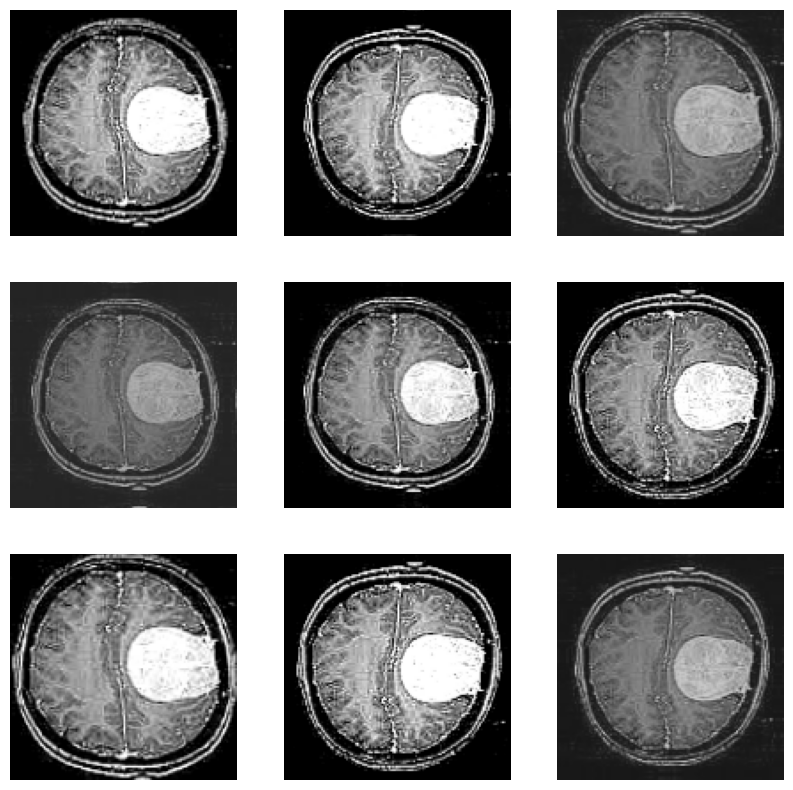

In [138]:
plt.figure(figsize=(10, 10))
for images, _ in train2.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

- no drop out in final model
- likely just not enough training data for it to matter

In [149]:
num_classes = len(class_names)


modelA = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # New Conv2D layer
    layers.MaxPooling2D(),  # New MaxPooling2D layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [150]:
modelA.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [151]:
%%time

# adding more because of the augmentation layer
epochs=25
history = modelA.fit(
  train,
  validation_data=validate,
  epochs=epochs
)

Epoch 1/25
25/25 [==============================] - 107s 4s/step - loss: 0.6468 - accuracy: 0.6482 - val_loss: 0.5316 - val_accuracy: 0.7305
Epoch 2/25
25/25 [==============================] - 101s 4s/step - loss: 0.5941 - accuracy: 0.6980 - val_loss: 0.5083 - val_accuracy: 0.7261
Epoch 3/25
25/25 [==============================] - 101s 4s/step - loss: 0.5298 - accuracy: 0.7415 - val_loss: 0.4802 - val_accuracy: 0.7555
Epoch 4/25
25/25 [==============================] - 102s 4s/step - loss: 0.4965 - accuracy: 0.7636 - val_loss: 0.4431 - val_accuracy: 0.8012
Epoch 5/25
25/25 [==============================] - 173s 7s/step - loss: 0.4450 - accuracy: 0.7907 - val_loss: 0.3958 - val_accuracy: 0.8189
Epoch 6/25
25/25 [==============================] - 101s 4s/step - loss: 0.4067 - accuracy: 0.8203 - val_loss: 0.3427 - val_accuracy: 0.8542
Epoch 7/25
25/25 [==============================] - 102s 4s/step - loss: 0.3306 - accuracy: 0.8575 - val_loss: 0.3380 - val_accuracy: 0.8380
Epoch 8/25
25

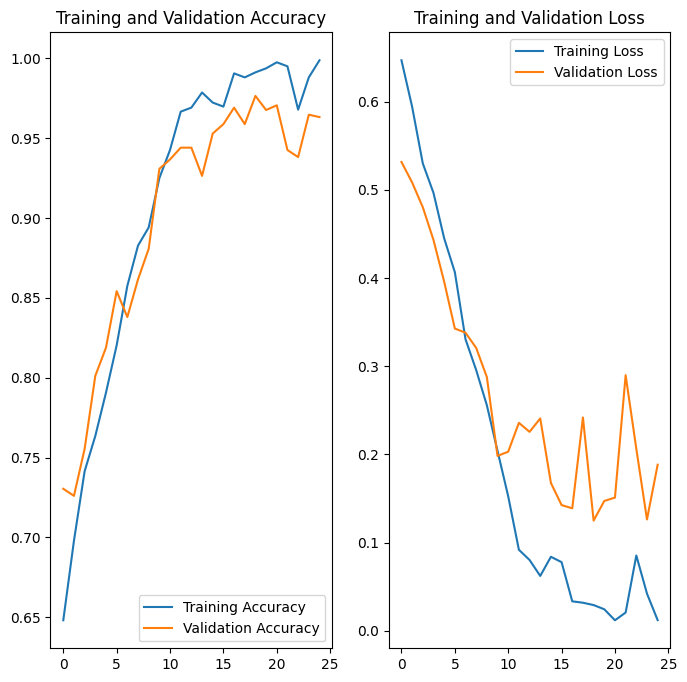

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [154]:
models = [modelA, model3]
modelnames = ["model", "model3"]

In [156]:
%%time

for moo in range(len(models)):
    MODELX= models[moo]


    correct_yes_count = 0
    correct_no_count = 0
    count_yes = 0
    count_no = 0

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = MODELX.predict(img_array, verbose=None)
            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)

    print(f"Model Name: \t {modelnames[moo]}")

    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}") 
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))




Model Name: 	 model
Accuracy: 96.13%
no: 19 / 490
rate of failure: 	 3.877551020408163
yes: 19 / 491
rate of failure: 	 3.8696537678207736
Model Name: 	 model3
Accuracy: 94.60%
no: 20 / 490
rate of failure: 	 4.081632653061225
yes: 33 / 491
rate of failure: 	 6.720977596741344
CPU times: total: 2min 3s
Wall time: 5min 16s


- simple model with no dropout and no augmentations which adjust the angles is most efficient
- concluding that the data is not going to be so different that the model will need to be very adaptable

###### final test on foreign dataset

In [166]:
%%time

# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./wdDataSet_ynFormat_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './wdDataSet_ynFormat_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions = modelA.predict(img_array, verbose=None)

        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 74.90%
no: 45 / 405
rate of failure: 	 11.11111111111111
yes: 284 / 906
rate of failure: 	 31.346578366445915
CPU times: total: 1min 59s
Wall time: 3min 48s


- much improved from previous models on the foreign dataset

### minimise false negatives
##### threshold adjustment and/or ensemble voting

In [164]:
thresholds = [0.55, 0.6, 0.65]

In [165]:
%%time

for new_threshold in thresholds:
    print(f"threshold set to {new_threshold}")

    # Create a dictionary to store false prediction counts for each class
    false_predictions = defaultdict(int)

    # Define the class names based on the folder names
    class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

    # Create a list to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Specify the path to the test dataset folder
    test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

    # Iterate through the test dataset
    for class_name in class_names:
        class_folder = os.path.join(test_data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)

            # Load and preprocess the image
            img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Make predictions
            predictions = modelA.predict(img_array, verbose=None)
            # threshold adjustment
            predictions = (predictions >= new_threshold).astype(int)

            predicted_class = class_names[np.argmax(predictions)]

            # Append true and predicted labels to the lists
            true_labels.append(class_name)
            predicted_labels.append(predicted_class)

            # Check if the prediction is correct
            if predicted_class != class_name:
                false_predictions[class_name] += 1

    # Calculate accuracy
    correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(correct_predictions)


    # Print accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

    def getpercent(numerator, denominator):
        return (numerator / denominator) * 100

    for class_name, wrong_count in false_predictions.items():
        class_folder = os.path.join(test_data_folder, class_name)
        files = os.listdir(class_folder)
        total_class_count = len(files)
        print(f"{class_name}: {wrong_count} / {total_class_count}")
        print("rate of failure: \t", getpercent(wrong_count, total_class_count))





threshold set to 0.55
Accuracy: 96.33%
no: 17 / 490
rate of failure: 	 3.4693877551020407
yes: 19 / 491
rate of failure: 	 3.8696537678207736
threshold set to 0.6
Accuracy: 96.33%
no: 17 / 490
rate of failure: 	 3.4693877551020407
yes: 19 / 491
rate of failure: 	 3.8696537678207736
threshold set to 0.65
Accuracy: 96.33%
no: 17 / 490
rate of failure: 	 3.4693877551020407
yes: 19 / 491
rate of failure: 	 3.8696537678207736
CPU times: total: 4min 25s
Wall time: 8min 41s


- threshold made no difference as the model has high confidence when wrong

- assuming ensemble voting needs odd number of models so using the 3 most successful models; "modelA" and "model3" and "model" as all had mid 90% accuracy
- also testing inclusion of "model2" as it had a bias for false positives as opposed to false negatives despite low overall accuracy

In [172]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions_modelA = modelA.predict(img_array, verbose=None)
        predictions_model3 = model3.predict(img_array, verbose=None)
        predictions_model = model.predict(img_array, verbose=None)

        #ensmeble vote - using confidence number average instead of class vote
        predictions = (predictions_modelA + predictions_model3 + predictions_model) / 3
        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 97.04%
no: 7 / 490
rate of failure: 	 1.4285714285714286
yes: 22 / 491
rate of failure: 	 4.480651731160896
CPU times: total: 3min 52s
Wall time: 9min 15s


- false negatives still a bit high 
- wall time increase pretty large with ensemble model

In [173]:
def ensemble_model_ConfidenceScore(img_array):
    predictions_modelA = modelA.predict(img_array, verbose=None)
    predictions_model3 = model3.predict(img_array, verbose=None)
    predictions_model = model.predict(img_array, verbose=None)

    predictions = (predictions_modelA + predictions_model3 + predictions_model) / 3
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

In [174]:
import statistics
from statistics import mode

def ensemble_model_BinaryClassVoting(img_array):
    predictions_modelA = modelA.predict(img_array, verbose=None)
    CLASS_modelA = class_names[np.argmax(predictions_modelA)]
    
    predictions_model3 = model3.predict(img_array, verbose=None)
    CLASS_model3 = class_names[np.argmax(predictions_model3)]
    
    predictions_model = model.predict(img_array, verbose=None)
    CLASS_model = class_names[np.argmax(predictions_model)]

    predicted_class = (mode([CLASS_modelA, CLASS_model3, CLASS_model]))
    return predicted_class

In [176]:
import statistics
from statistics import mode

def Biased_ensemble_model_BinaryClassVoting(img_array):
    predictions_modelA = modelA.predict(img_array, verbose=None)
    CLASS_modelA = class_names[np.argmax(predictions_modelA)]
    
    predictions_model3 = model3.predict(img_array, verbose=None)
    CLASS_model3 = class_names[np.argmax(predictions_model3)]
    
    predictions_model = model.predict(img_array, verbose=None)
    CLASS_model = class_names[np.argmax(predictions_model)]
    
    if "yes" in [CLASS_modelA, CLASS_model3, CLASS_model]:
        return "yes"
    else:
        return "no"


In [179]:
# could remove one to reduce walltime
def ErrorBiased_ensemble_model_BinaryClassVoting(img_array):
    predictions_modelA = modelA.predict(img_array, verbose=None)
    CLASS_modelA = class_names[np.argmax(predictions_modelA)]
    
    predictions_model3 = model3.predict(img_array, verbose=None)
    CLASS_model3 = class_names[np.argmax(predictions_model3)]
    
    predictions_model = model.predict(img_array, verbose=None)
    CLASS_model = class_names[np.argmax(predictions_model)]
    
    predictions_model2 = model2.predict(img_array, verbose=None)
    CLASS_model2 = class_names[np.argmax(predictions_model2)]
    
    if "yes" in [CLASS_modelA, CLASS_model3, CLASS_model, CLASS_model2]:
        return "yes"
    else:
        return "no"


In [175]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predicted_class = ensemble_model_BinaryClassVoting(img_array)

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 96.94%
no: 8 / 490
rate of failure: 	 1.6326530612244898
yes: 22 / 491
rate of failure: 	 4.480651731160896
CPU times: total: 4min 6s
Wall time: 9min 44s


- minorly worse

In [177]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predicted_class = Biased_ensemble_model_BinaryClassVoting(img_array)

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 95.92%
no: 33 / 490
rate of failure: 	 6.73469387755102
yes: 7 / 491
rate of failure: 	 1.4256619144602851
CPU times: total: 3min 58s
Wall time: 10min 30s


- best so far

In [180]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predicted_class = Biased_ensemble_model_BinaryClassVoting(img_array)

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))


Accuracy: 95.92%
no: 33 / 490
rate of failure: 	 6.73469387755102
yes: 7 / 491
rate of failure: 	 1.4256619144602851
CPU times: total: 4min 1s
Wall time: 11min 9s


##### ^^^ ignore above result - never chagned the fucntion name

> introduce either leaky relu or parametric relu

In [182]:
modelA.save('./model_1A/')
model3.save('./model_1B/')
model.save('./model_1C/')
model2.save('./model_1D/')

INFO:tensorflow:Assets written to: ./model_1A/assets


INFO:tensorflow:Assets written to: ./model_1A/assets


INFO:tensorflow:Assets written to: ./model_1B/assets


INFO:tensorflow:Assets written to: ./model_1B/assets


INFO:tensorflow:Assets written to: ./model_1C/assets


INFO:tensorflow:Assets written to: ./model_1C/assets


INFO:tensorflow:Assets written to: ./model_1D/assets


INFO:tensorflow:Assets written to: ./model_1D/assets


### Leaky ReLU Model

In [2]:
batch_size = 64
image_height = 128
image_width = 128

In [3]:
train4 = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='training',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)

valid4 = tf.keras.utils.image_dataset_from_directory(
    './LowRes+Original_Train',
    labels='inferred',
    validation_split=0.3,
    subset='validation',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 2265 files belonging to 2 classes.
Using 1586 files for training.
Found 2265 files belonging to 2 classes.
Using 679 files for validation.


In [5]:
class_names = train4.class_names
class_names

['no', 'yes']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train4 = train4.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
valid4 = valid4.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)


In [8]:
normalized_ds = train4.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.99998784


In [9]:
data_augmentation = tf.keras.Sequential([
    # Adjust brightness and contrast
    # there is some variance in this area in the data so probably useful
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_brightness(x, 2.5)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.8),    
    # flips it upside down
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    # flips it other way
    tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
    # random zoom kept small because dont want to exclude tumour
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [12]:
from tensorflow.keras.layers import LeakyReLU


In [13]:
num_classes = len(class_names)

model4 = Sequential([
    data_augmentation, 
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(320, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  
    layers.Flatten(),
    layers.Dense(128, activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dense(num_classes, name="outputs")
])


In [14]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
%%time

epochs=35
history = model4.fit(
  train4,
  validation_data=valid4,
  epochs=epochs
)

Epoch 1/35
25/25 [==============================] - 19s 566ms/step - loss: 0.6498 - accuracy: 0.6545 - val_loss: 0.5517 - val_accuracy: 0.7334
Epoch 2/35
25/25 [==============================] - 13s 506ms/step - loss: 0.5603 - accuracy: 0.7144 - val_loss: 0.5231 - val_accuracy: 0.7334
Epoch 3/35
25/25 [==============================] - 12s 498ms/step - loss: 0.5416 - accuracy: 0.7301 - val_loss: 0.4767 - val_accuracy: 0.7599
Epoch 4/35
25/25 [==============================] - 13s 507ms/step - loss: 0.4701 - accuracy: 0.7825 - val_loss: 0.4217 - val_accuracy: 0.8130
Epoch 5/35
25/25 [==============================] - 13s 512ms/step - loss: 0.4099 - accuracy: 0.8222 - val_loss: 0.3278 - val_accuracy: 0.8542
Epoch 6/35
25/25 [==============================] - 17s 684ms/step - loss: 0.3552 - accuracy: 0.8474 - val_loss: 0.3455 - val_accuracy: 0.8365
Epoch 7/35
25/25 [==============================] - 22s 815ms/step - loss: 0.3331 - accuracy: 0.8638 - val_loss: 0.3213 - val_accuracy: 0.8542

In [16]:
%%time
# running a few more epochs to optimize
epochs=7
history = model4.fit(
  train4,
  validation_data=valid4,
  epochs=epochs
)

Epoch 1/7
25/25 [==============================] - 12s 491ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.1733 - val_accuracy: 0.9750
Epoch 2/7
25/25 [==============================] - 12s 492ms/step - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.1612 - val_accuracy: 0.9764
Epoch 3/7
25/25 [==============================] - 12s 499ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.2066 - val_accuracy: 0.9705
Epoch 4/7
25/25 [==============================] - 12s 492ms/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.1817 - val_accuracy: 0.9558
Epoch 5/7
25/25 [==============================] - 13s 502ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.3189 - val_accuracy: 0.9588
Epoch 6/7
25/25 [==============================] - 12s 493ms/step - loss: 0.0611 - accuracy: 0.9849 - val_loss: 0.1882 - val_accuracy: 0.9647
Epoch 7/7
25/25 [==============================] - 13s 505ms/step - loss: 0.0229 - accuracy: 0.9899 - val_loss: 0.1305 - val_accuracy: 0.9720
CPU ti

In [20]:
%%time

# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions = model4.predict(img_array, verbose=None)
        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))


Accuracy: 96.64%
no: 6 / 490
rate of failure: 	 1.2244897959183674
yes: 27 / 491
rate of failure: 	 5.4989816700611
CPU times: total: 23.8 s
Wall time: 53.3 s


- pretty poor for false negatives
- computation time faster

In [22]:
#modelA.save('./model_1A/')
#model3.save('./model_1B/')
#model.save('./model_1C/')
#model2.save('./model_1D/')

model1A = keras.models.load_model('./model_1A')
model1B = keras.models.load_model('./model_1B')
model1C = keras.models.load_model('./model_1C')
model1D = keras.models.load_model('./model_1D')



In [23]:
#modelA.save('./model_1A/')
#model3.save('./model_1B/')
#model.save('./model_1C/')
#model2.save('./model_1D/')

import statistics
from statistics import mode

def LeakyRelu_Biased_ensemble_model_BinaryClassVoting(img_array):
    predictions_model1A = model1A.predict(img_array, verbose=None)
    CLASS_model1A = class_names[np.argmax(predictions_model1A)]
    
    predictions_model1B = model1B.predict(img_array, verbose=None)
    CLASS_model1B = class_names[np.argmax(predictions_model1B)]
    
    predictions_model1C = model1C.predict(img_array, verbose=None)
    CLASS_model1C = class_names[np.argmax(predictions_model1C)]
    
    predictions_model4_Leaky = model4.predict(img_array, verbose=None)
    CLASS_model4_Leaky = class_names[np.argmax(predictions_model4_Leaky)]
    
    
    if "yes" in [CLASS_model1A, CLASS_model1B, CLASS_model1C, CLASS_model4_Leaky]:
        return "yes"
    else:
        return "no"

In [24]:
# could remove one to reduce walltime
def ErrorBiased_ensemble_model_BinaryClassVoting(img_array):
    predictions_model1A = model1A.predict(img_array, verbose=None)
    CLASS_model1A = class_names[np.argmax(predictions_model1A)]
    
    predictions_model1B = model1B.predict(img_array, verbose=None)
    CLASS_model1B = class_names[np.argmax(predictions_model1B)]
    
    predictions_model1C = model1C.predict(img_array, verbose=None)
    CLASS_model1C = class_names[np.argmax(predictions_model1C)]
    
    predictions_model1D = model1D.predict(img_array, verbose=None)
    CLASS_model1D = class_names[np.argmax(predictions_model1D)]
    
    if "yes" in [CLASS_model1A, CLASS_model1B, CLASS_model1C, CLASS_model1D]:
        return "yes"
    else:
        return "no"


- including the least accurate model for bias

In [25]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predicted_class = ErrorBiased_ensemble_model_BinaryClassVoting(img_array)

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 77.57%
no: 215 / 490
rate of failure: 	 43.87755102040816
yes: 5 / 491
rate of failure: 	 1.0183299389002036
CPU times: total: 55.3 s
Wall time: 3min 31s


- good for false negatives but not accurate enough
- walltime somehow much lower -may have just been high yesterday because of other applications running on computer

In [28]:
%%time

#track the files that it cannot predict on for inspection
capture_mistake_false_negative = []

# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./LowRes+Original_Test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './LowRes+Original_Test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predicted_class = LeakyRelu_Biased_ensemble_model_BinaryClassVoting(img_array)

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)

        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1
            if class_name =="yes":
                capture_mistake_false_negative.append(image_path)

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))





Accuracy: 95.82%
no: 35 / 490
rate of failure: 	 7.142857142857142
yes: 6 / 491
rate of failure: 	 1.2219959266802443
CPU times: total: 1min 26s
Wall time: 5min 3s


- best result so far but still couldn't make it to 0 false negatives
- workable solution

In [30]:
model4.save("./model_1E/")

INFO:tensorflow:Assets written to: ./model1E/assets


INFO:tensorflow:Assets written to: ./model1E/assets


In [29]:
capture_mistake_false_negative

['./LowRes+Original_Test\\yes\\y1395.jpg',
 './LowRes+Original_Test\\yes\\y1399.jpg',
 './LowRes+Original_Test\\yes\\y1414.jpg',
 './LowRes+Original_Test\\yes\\y1427.jpg',
 './LowRes+Original_Test\\yes\\y745.jpg',
 './LowRes+Original_Test\\yes\\y943.jpg']

### 6 instances unable to predict tumor - more obvious than the missed tumors in other notebook
<img src="./LowRes+Original_Test/yes/y1395.jpg" alt="alt text" width="30%" height="auto" class="blog-image">
<img src="./LowRes+Original_Test/yes/y1399.jpg" alt="alt text" width="30%" height="auto" class="blog-image">
<img src="./LowRes+Original_Test/yes/y1414.jpg" alt="alt text" width="30%" height="auto" class="blog-image">
<img src="./LowRes+Original_Test/yes/y1427.jpg" alt="alt text" width="30%" height="auto" class="blog-image">
<img src="./LowRes+Original_Test/yes/y745.jpg" alt="alt text" width="30%" height="auto" class="blog-image">
<img src="./LowRes+Original_Test/yes/y943.jpg" alt="alt text" width="30%" height="auto" class="blog-image">